In [1]:
import math
import itertools

import pandas as pd
from sqlalchemy.sql import select

from predict_aqi.load_data import (
    AirLocation, get_db_session, load_air_location_data, load_measurement_data,
    load_nearby_locations
)

# Select some airlocation with bad aqi
session = get_db_session()
s = select([AirLocation]).where(AirLocation.aqi > 100)
some_airlocation_ids = [x['id'] for x in session.execute(s)]

/opt/conda/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:2503: SAWarning: Did not recognize type 'geometry' of column 'coordinates'
  (attype, name))


In [2]:
from predict_aqi.multi_city_model import load_and_clean_locations_near_airlocation

NUMBER_OF_NEARBY_LOCATIONS = 5

df, airlocation_ids, continuous_time_series = load_and_clean_locations_near_airlocation(
    some_airlocation_ids[20], 
    50,
    max_locations=NUMBER_OF_NEARBY_LOCATIONS,
    print_progress=True
)
print("AirLocation ids used: {}".format(str(airlocation_ids)))

Predicting for: Chengdu Shi
Using nearby locations: ['China/成都/沙河铺', 'China/成都/三瓦窑', 'China/成都/成都市第二行政学院', 'China/成都/双流县环境监测站', 'China/成都/新都区环境监测站', 'China/成都/龙泉驿区环境监测站', 'China/成都/玉林', 'China/成都/君平街', 'China/成都/人民公园', 'China/成都/丽都花园', 'China/成都/大石西路', 'Chengdu', 'China/成都/郫县党校', 'China/成都/团结镇', 'China/成都/城厢镇', 'China/成都/彭州市环保局', 'Deyang', 'China/眉山/仁寿县国土局', 'Meishan', 'China/成都/邛崃水业公司', 'Ziyang', 'Mianyang', 'Leshan', 'China/绵阳/富乐山', 'China/雅安/宝兴县环保局']


36037 rows loaded for loc #964


37522 rows loaded for loc #802


37535 rows loaded for loc #633


36276 rows loaded for loc #444


35934 rows loaded for loc #420


Aligning data took 180.994494 seconds
AirLocation ids used: [964, 802, 633, 444, 420]


[0.0, 120000000.0, 0.0, 300.0]

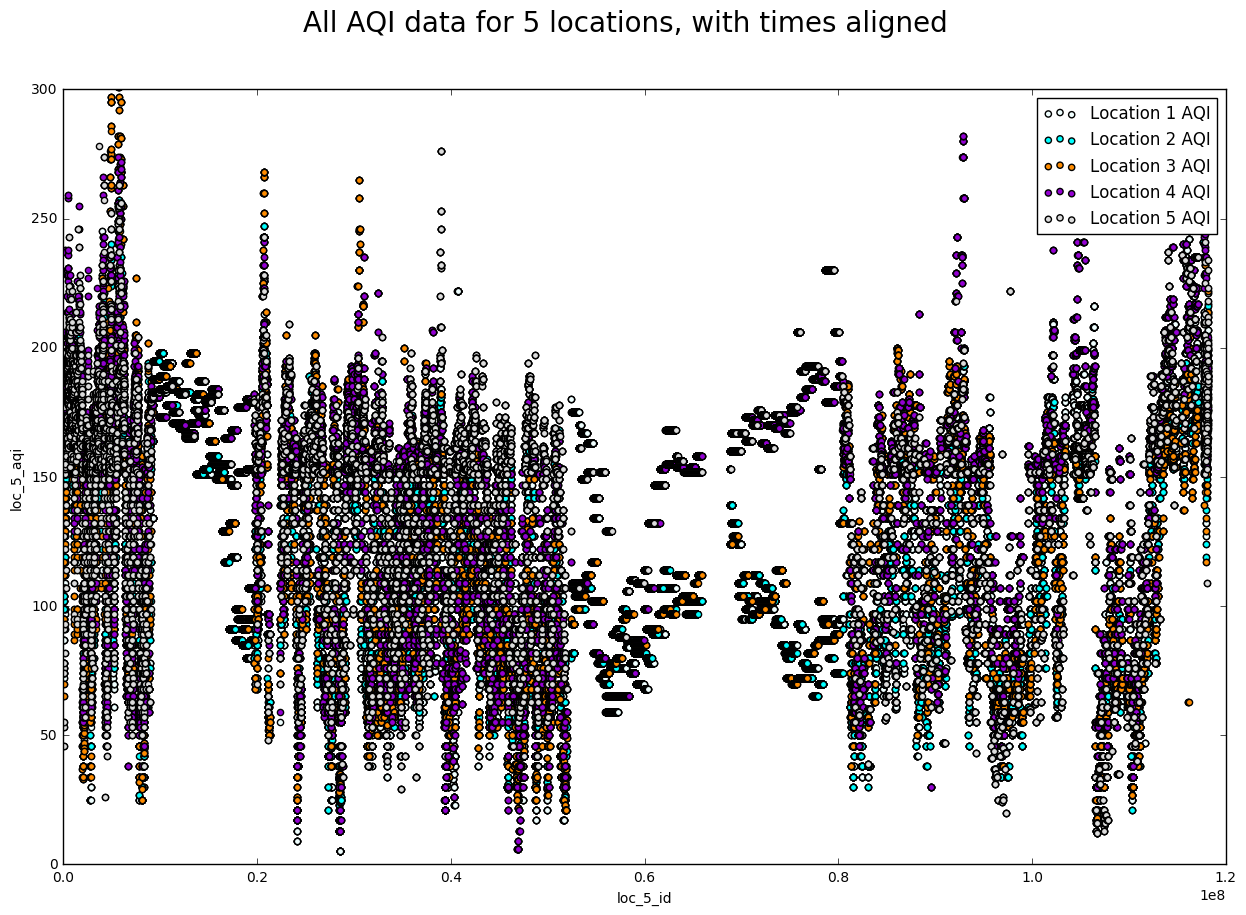

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
colours = sorted(list(cnames.keys()))
aqi_graph = df.plot.scatter(x='loc_1_id', y='loc_1_aqi', label="Location 1 AQI", color=colours[4])
for loc_num in range(2, NUMBER_OF_NEARBY_LOCATIONS + 1):
    df.plot.scatter(
        x='loc_{}_id'.format(loc_num), 
        y='loc_{}_aqi'.format(loc_num), 
        label="Location {} AQI".format(loc_num), 
        color=colours[loc_num*10], 
        ax=aqi_graph
    )

fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("All AQI data for {} locations, with times aligned".format(NUMBER_OF_NEARBY_LOCATIONS), fontsize=20)
aqi_graph.axis([0.0, 120000000.0, 0.0, 300.0])

In [4]:
# Select classifier to use
from predict_aqi.multi_city_model import generate_AQI_inputs_and_outputs
from predict_aqi import config
from predict_aqi.transform_data import clean_data, generate_time_inputs

MAX_INDEX = 48
INDICES_AHEAD_TO_PREDICT = range(2, config.NUMBER_AHEAD_TO_PREDICT + 2, 4)
LAST_INDEX_BEHIND_TO_USE = 24
indices_behind_to_use = range(LAST_INDEX_BEHIND_TO_USE + 1)
locations = ['loc_{}'.format(str(i)) for i in range(1, NUMBER_OF_NEARBY_LOCATIONS + 1)]

df, continuous_time_series, input_columns, output_columns = generate_AQI_inputs_and_outputs(
    df, continuous_time_series, INDICES_AHEAD_TO_PREDICT, indices_behind_to_use, NUMBER_OF_NEARBY_LOCATIONS
)

/home/jovyan/work/predict_aqi/transform_data.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  new_df['is_dirty'] = new_df[output_columns].apply(lambda x: any(map(np.isnan, x)), axis=1)


In [5]:
print(df.shape)
print(input_columns)
print(output_columns)

(23492, 166)
['minute_of_day_sin', 'minute_of_day_cos', 'day_of_year_cos', 'day_of_year_sin', 'day_of_week_cos', 'day_of_week_sin', 'day_of_month_sin', 'day_of_month_cos', '0_ago_loc_1', '1_ago_loc_1', '2_ago_loc_1', '3_ago_loc_1', '4_ago_loc_1', '5_ago_loc_1', '6_ago_loc_1', '7_ago_loc_1', '8_ago_loc_1', '9_ago_loc_1', '10_ago_loc_1', '11_ago_loc_1', '12_ago_loc_1', '13_ago_loc_1', '14_ago_loc_1', '15_ago_loc_1', '16_ago_loc_1', '17_ago_loc_1', '18_ago_loc_1', '19_ago_loc_1', '20_ago_loc_1', '21_ago_loc_1', '22_ago_loc_1', '23_ago_loc_1', '24_ago_loc_1', '0_ago_loc_2', '1_ago_loc_2', '2_ago_loc_2', '3_ago_loc_2', '4_ago_loc_2', '5_ago_loc_2', '6_ago_loc_2', '7_ago_loc_2', '8_ago_loc_2', '9_ago_loc_2', '10_ago_loc_2', '11_ago_loc_2', '12_ago_loc_2', '13_ago_loc_2', '14_ago_loc_2', '15_ago_loc_2', '16_ago_loc_2', '17_ago_loc_2', '18_ago_loc_2', '19_ago_loc_2', '20_ago_loc_2', '21_ago_loc_2', '22_ago_loc_2', '23_ago_loc_2', '24_ago_loc_2', '0_ago_loc_3', '1_ago_loc_3', '2_ago_loc_3', '3_

[0.0, 120000000.0, 0.0, 300.0]

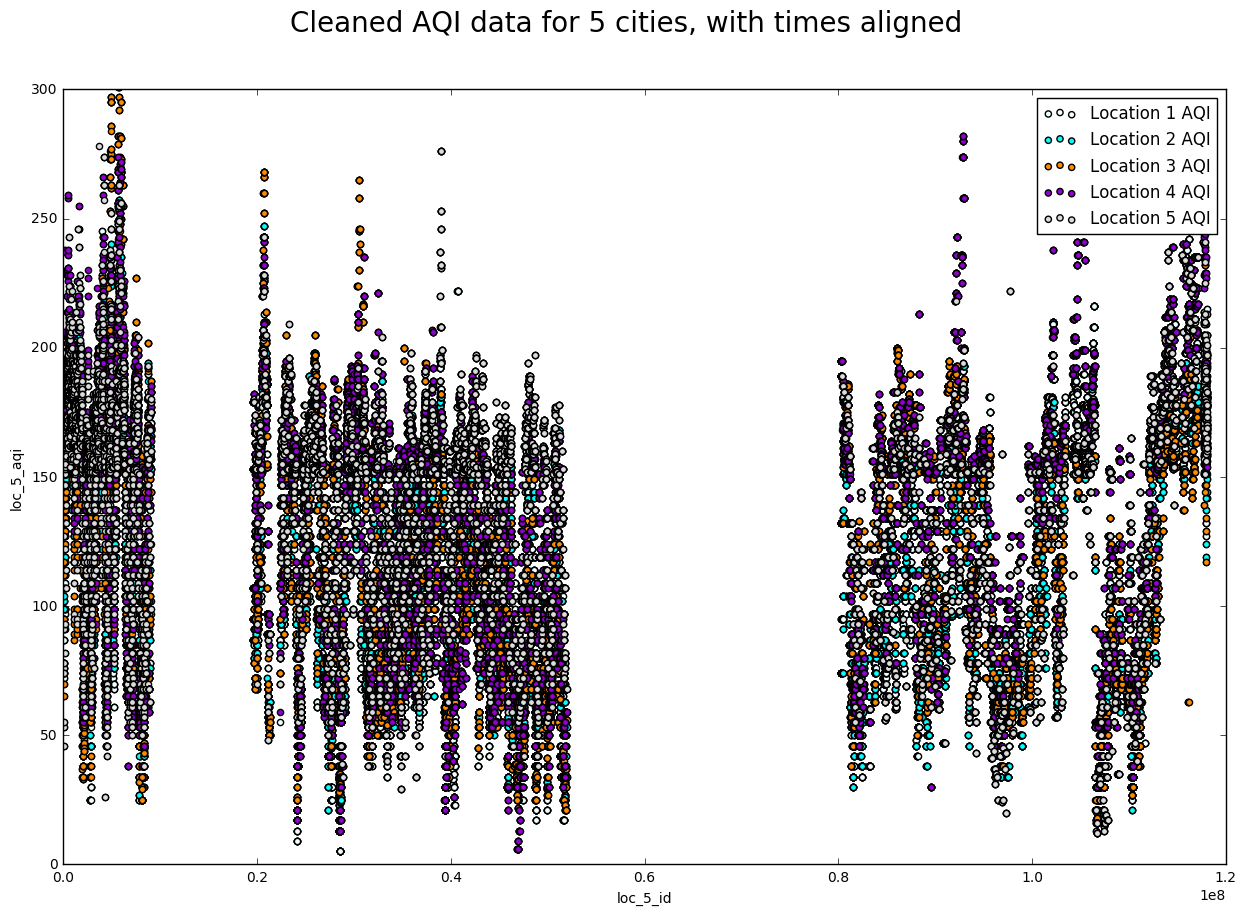

In [6]:
aqi_graph = df[df['is_dirty'] == False].plot.scatter(x='loc_1_id', y='loc_1_aqi', label="Location 1 AQI", color=colours[4])
for loc_num in range(2, NUMBER_OF_NEARBY_LOCATIONS + 1):
    df.plot.scatter(
        x='loc_{}_id'.format(loc_num), 
        y='loc_{}_aqi'.format(loc_num), 
        label="Location {} AQI".format(loc_num), 
        color=colours[loc_num*10], 
        ax=aqi_graph
    )

fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("Cleaned AQI data for {} cities, with times aligned".format(NUMBER_OF_NEARBY_LOCATIONS), fontsize=20)
aqi_graph.axis([0.0, 120000000.0, 0.0, 300.0])

In [7]:
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from predict_aqi.predictor_utils import train_regressor, predict_values
from predict_aqi.transform_data import (
    generate_time_inputs
)
from predict_aqi.multi_city_model import (
    generate_predictions_two_step, cut_off_end_split_function, generate_baseline_predictions
)

row_count = df.count()[0]
split_row = int(round(row_count * 0.90))

df, second_step_additional_features = generate_time_inputs(df, time_column="loc_1_measurement_datetime")

output_columns = ["{}_ahead_AQI".format(str(i)) for i in INDICES_AHEAD_TO_PREDICT]


# Make baseline predictions
baseline_df = df.copy(deep=True)
baseline_df = generate_baseline_predictions(baseline_df, output_columns)

# Make predictions with 1 city
# make regressors for each index ahead to predict
locations = ['loc_1']
first_step_regressors = [MLPRegressor() for i in locations]
second_step_regressors = [MLPRegressor() for i in INDICES_AHEAD_TO_PREDICT]


# generate predictions
single_city_df = df.copy(deep=True)
single_city_df = generate_predictions_two_step(
    single_city_df,
    second_step_additional_features,
    output_columns,
    cut_off_end_split_function,
    locations,
    first_step_regressors,
    second_step_regressors,
    INDICES_AHEAD_TO_PREDICT,
    indices_behind_to_use,
    "ahead_single_city_pred",
    False
)

# Make predictions with 3 cities
# make regressors for each index ahead to predict
locations = ['loc_1', 'loc_2', 'loc_3', 'loc_4', 'loc_5']
first_step_regressors = [MLPRegressor() for i in locations]
second_step_regressors = [MLPRegressor() for i in INDICES_AHEAD_TO_PREDICT]

three_city_df = df.copy(deep=True)
three_city_df = generate_predictions_two_step(
    three_city_df,
    second_step_additional_features,
    output_columns,
    cut_off_end_split_function,
    locations,
    first_step_regressors,
    second_step_regressors,
    INDICES_AHEAD_TO_PREDICT,
    indices_behind_to_use,
    "ahead_three_city_pred",
    False
)

/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
print(list(three_city_df.columns))

['loc_1_id', 'loc_1_measurement_datetime', 'loc_1_aqi', 'loc_2_id', 'loc_2_measurement_datetime', 'loc_2_aqi', 'loc_3_id', 'loc_3_measurement_datetime', 'loc_3_aqi', 'loc_4_id', 'loc_4_measurement_datetime', 'loc_4_aqi', 'loc_5_id', 'loc_5_measurement_datetime', 'loc_5_aqi', 'loc_1_normalized_AQI', 'loc_2_normalized_AQI', 'loc_3_normalized_AQI', 'loc_4_normalized_AQI', 'loc_5_normalized_AQI', '2_ahead_AQI', '6_ahead_AQI', '10_ahead_AQI', '14_ahead_AQI', '18_ahead_AQI', '22_ahead_AQI', '26_ahead_AQI', '30_ahead_AQI', '34_ahead_AQI', '38_ahead_AQI', '42_ahead_AQI', '46_ahead_AQI', 'minute_of_day_sin', 'minute_of_day_cos', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin', 'day_of_month_cos', '0_ago_loc_1', '1_ago_loc_1', '2_ago_loc_1', '3_ago_loc_1', '4_ago_loc_1', '5_ago_loc_1', '6_ago_loc_1', '7_ago_loc_1', '8_ago_loc_1', '9_ago_loc_1', '10_ago_loc_1', '11_ago_loc_1', '12_ago_loc_1', '13_ago_loc_1', '14_ago_loc_1', '15_ago_loc_1', '16_ago_lo

In [9]:
errors = {
    'single_city_pred': {}, 
    'three_city_pred': {}, 
    'baseline_pred': {}, 
    'first_city_pred': {}, 
    'second_city_pred': {},
    'third_city_pred': {}
}
for i in INDICES_AHEAD_TO_PREDICT:
    actual_column = '{}_ahead_AQI'.format(i)
    three_city_pred_column = '{}_ahead_three_city_pred'.format(i)
    first_city_pred_column = '{}_ahead_loc_1_first_step_pred'.format(i)
    second_city_pred_column = '{}_ahead_loc_2_first_step_pred'.format(i)
    third_city_pred_column = '{}_ahead_loc_3_first_step_pred'.format(i)
    single_city_pred_column = '{}_ahead_single_city_pred'.format(i)
    baseline_pred_column = '{}_ahead_baseline_pred'.format(i)
    
    single_city_df[single_city_pred_column] = single_city_df[single_city_pred_column].apply(lambda x: x * 300)
    three_city_df[three_city_pred_column] = three_city_df[three_city_pred_column].apply(lambda x: x * 300)
    three_city_df[first_city_pred_column] = three_city_df[first_city_pred_column].apply(lambda x: x * 300)
    three_city_df[second_city_pred_column] = three_city_df[second_city_pred_column].apply(lambda x: x * 300)
    three_city_df[third_city_pred_column] = three_city_df[third_city_pred_column].apply(lambda x: x * 300)
    single_city_df[actual_column] = single_city_df[actual_column].apply(lambda x: x * 300)
    
    errors['single_city_pred'][i] = mean_absolute_error(
        single_city_df[actual_column], 
        single_city_df[single_city_pred_column]
    )
    errors['three_city_pred'][i] = mean_absolute_error(
        single_city_df[actual_column], 
        three_city_df[three_city_pred_column]
    )
    errors['first_city_pred'][i] = mean_absolute_error(
        single_city_df[actual_column], 
        three_city_df[first_city_pred_column]
    )
    errors['second_city_pred'][i] = mean_absolute_error(
        single_city_df[actual_column], 
        three_city_df[second_city_pred_column]
    )
    errors['third_city_pred'][i] = mean_absolute_error(
        single_city_df[actual_column], 
        three_city_df[third_city_pred_column]
    )
    errors['baseline_pred'][i] = mean_absolute_error(
        single_city_df[actual_column], 
        baseline_df[baseline_pred_column]
    )

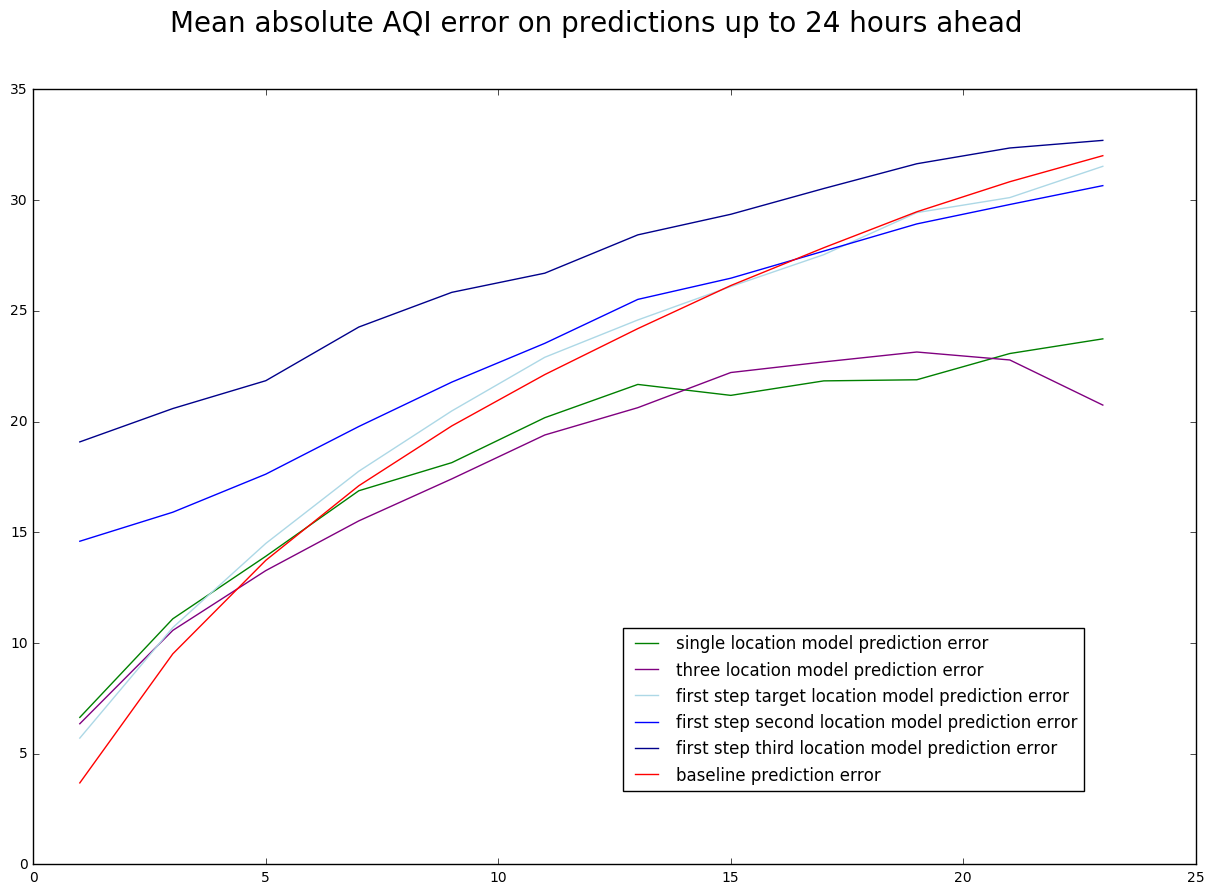

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.axis([0.0, 25.0, 0.0, 35.0])
plt.plot(
    [h // 2 for h in INDICES_AHEAD_TO_PREDICT],
    [errors['single_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT], 
    label="single location model prediction error",
    color="Green"
)
plt.plot(
    [h // 2 for h in INDICES_AHEAD_TO_PREDICT],
    [errors['three_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT], 
    label="three location model prediction error",
    color="Purple"
)
plt.plot(
    [h // 2 for h in INDICES_AHEAD_TO_PREDICT],
    [errors['first_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT], 
    label="first step target location model prediction error",
    color="LightBlue"
)
plt.plot(
    [h // 2 for h in INDICES_AHEAD_TO_PREDICT],
    [errors['second_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT], 
    label="first step second location model prediction error",
    color="Blue"
)
plt.plot(
    [h // 2 for h in INDICES_AHEAD_TO_PREDICT],
    [errors['third_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT], 
    label="first step third location model prediction error",
    color="DarkBlue"
)
plt.plot(
    [h // 2 for h in INDICES_AHEAD_TO_PREDICT],
    [errors['baseline_pred'][i] for i in INDICES_AHEAD_TO_PREDICT], 
    label="baseline prediction error",
    color="Red"
)
plt.legend(loc=6, bbox_to_anchor=(0.5, 0.2))
plt.suptitle("Mean absolute AQI error on predictions up to 24 hours ahead", fontsize=20)

In [11]:
print("The average of each hour ahead's average absolute error (of the 24 different hours ahead predicted).")
print("Baseline error : {}".format(sum([errors['baseline_pred'][i] for i in INDICES_AHEAD_TO_PREDICT])))
print("Three city model error: {}".format(sum([errors['three_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT])))
print("Single city model error: {}".format(sum([errors['single_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT])))

The average of each hour ahead's average absolute error (of the 24 different hours ahead predicted).
Baseline error : 256.4676911288949
Three city model error: 214.7298110906915
Single city model error: 220.25056094110178
